# Starbucks Capstone Challenge

### Project Overview
 * This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks.
 
 * We will follow CRISP-DM (Cross-Industry Standard Process for Data Mining) process
     - Business Understanding
     - Data Understanding
     - Data Preparation
     - Modelling
     - Evaluation
     - Deployment

## Business Understanding

Starbucks has kindly provided simulated promotional datasets that mimic customer behavior on the rewards mobile app. The promotion runs like the following: once every few days, Starbucks will send out promotions to customers. The promotions could be discount offers, buy-one-get-one-free (bogo) offers, or informational offers. Different customers might react differently to the offers. Some customers will react positively to the promotions (viewed the offer and placed an order), whereas other customer might ignore the promotions (did not place an order after viewing the promotions, or placed an order without noticing the promotions). Since there is a cost associated with the promotion, analysis of the data could be helpful for understanding customer behaviors, making business decision, and implementing strategies to improve the business profits.

- In this analysis, we are interested in the following questions:
    - Was there a pattern in the release of offers?
    - What were the most common offer types by channel?
    - What is the best channel to send out promotions?
    - Can we build a model to predict the customers' behavior and send out customized promotional offers to individuals?

## Data Understanding

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
# Import relevant modules
import datetime
import pandas as pd
from ydata_profiling import ProfileReport
import numpy as np
import math
import json
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MultiLabelBinarizer

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

C:\ProgramData\Anaconda3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Profiling 

- We will use pandas profiling to generate exploratory data analysis (EDA) a consistent and fast solution for visualizing the data.
- We will export the EDA to an html file.

In [96]:
# portfolio
profile_portfolio = ProfileReport(portfolio, title="Profiling Report Portfolio")
profile_portfolio.to_file("eda/eda_portfolio.html")

# profile
profile_profile = ProfileReport(profile, title="Profiling Report profile")
profile_profile.to_file("eda/eda_profile.html")

# transcript
profile_transcript = ProfileReport(transcript, title="Profiling Report transcript")
profile_transcript.to_file("eda/eda_transcript.html")


Export report to file: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 998.88it/s]


## Data Preparation

* Transcript Data:
    - offer id and transaction_amount columns created from extracting data from value column
    - time converted from hours to days to create column days_since_test_start
    - person renamed to customer_id
    - time renamed to time_hours

### User Defined Functions

In [2]:
def print_line(title='Default Title'):
    ''' Function to format titles nicely '''
    print(50 * '*' + '\n\t\t' + title + '\n' + 50 * '*')
    
    return


def get_offer_id(x):
    '''Get offer_id from value column either by indexing on 'offer_id' or 'offer id' '''
    try :
        return x['offer id']
    except:
        return x['offer_id']
    
    
def plot_conf_mat(y_test, y_pred):
    '''Plots a confusion matrix using Seaborn's heatmap()'''
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(confusion_matrix(y_test, y_pred),
    annot=True, # Annotate the boxes
    fmt='g',
    cbar=False)
    plt.xlabel("true label")
    plt.ylabel("predicted label")
    

In [3]:
# rename person to customer_id
transcript.rename(columns={'person':'customer_id', 'time':'time_hours'}, inplace=True)

# check if there are any customer IDs which do not appear in profile df, drop if they exist
transcript['customer_id_in_profile'] = transcript['customer_id'].isin(profile['id']).astype(int)
transcript = transcript[transcript.customer_id_in_profile == 1]

# convert time from hours to days for exploratory analysis purposes
transcript['days_since_test_start'] = (transcript['time_hours']/24).astype(int)

# extract offer id or transaction amount from value column
transcript['offer_id'] = transcript[transcript.event.isin(['offer received', 'offer viewed', 'offer completed'])]\
    .value.apply(lambda x: get_offer_id(x))
transcript['transaction_amount'] =  transcript[transcript.event.isin(['transaction'])].value.apply(lambda x: x['amount'])

# drop unused columns
transcript.drop(['customer_id_in_profile', 'value'], axis=1, inplace=True)

### Was there a pattern in the release of offers?

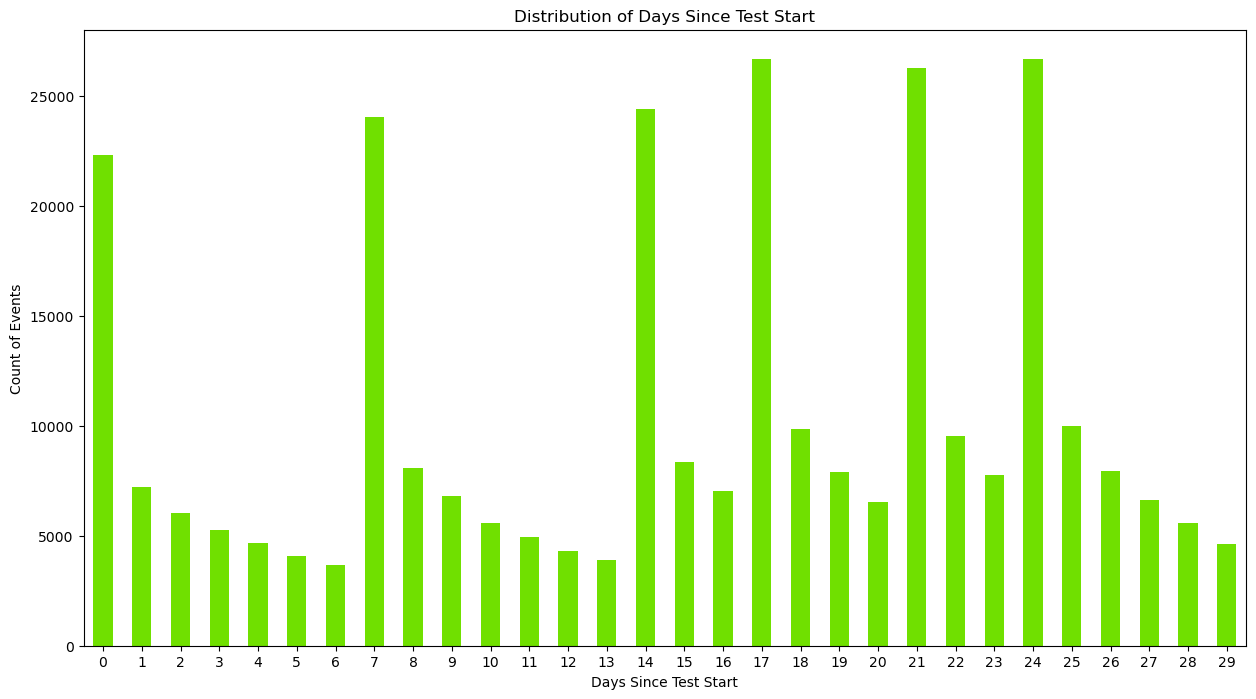

In [4]:
fig, ax = plt.subplots(figsize=(15,8))

transcript.days_since_test_start.value_counts().sort_index().plot(kind='bar', ax=ax, color=["#70e000"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_title('Distribution of Days Since Test Start')
ax.set_ylabel('Count of Events')
ax.set_xlabel('Days Since Test Start');

When we look at the distribution of time (converted to days) since test start, we can see clear spikes on days 0,7,14,21, etc. which suggests that the tests perhaps commence weekly or that there is clear scheduling behind receiving offers and completing offers.

***

### What were the most common offer types by channel?

In [5]:
# one hot encode offers, save to separate df and concat with portfolio df
offer_type_dummies = pd.get_dummies(portfolio['offer_type'], prefix = 'offer')
portfolio = pd.concat([portfolio,offer_type_dummies], axis = 1)

mlb = MultiLabelBinarizer()

# one hot encode channels, save to separate df and concat with portfolio df
ohe_channels = mlb.fit_transform(portfolio['channels'])
df_channels = pd.DataFrame(data=ohe_channels, columns=mlb.classes_)
portfolio = pd.concat([portfolio,df_channels], axis=1)
# drop original columns
# portfolio.drop(['channels'], axis=1, inplace=True)

# add prefix to ohe columns
portfolio.rename(columns = {'email':'channel_email', 'mobile':'channel_mobile', \
                            'social':'channel_social', 'web':'channel_web'}, inplace=True)

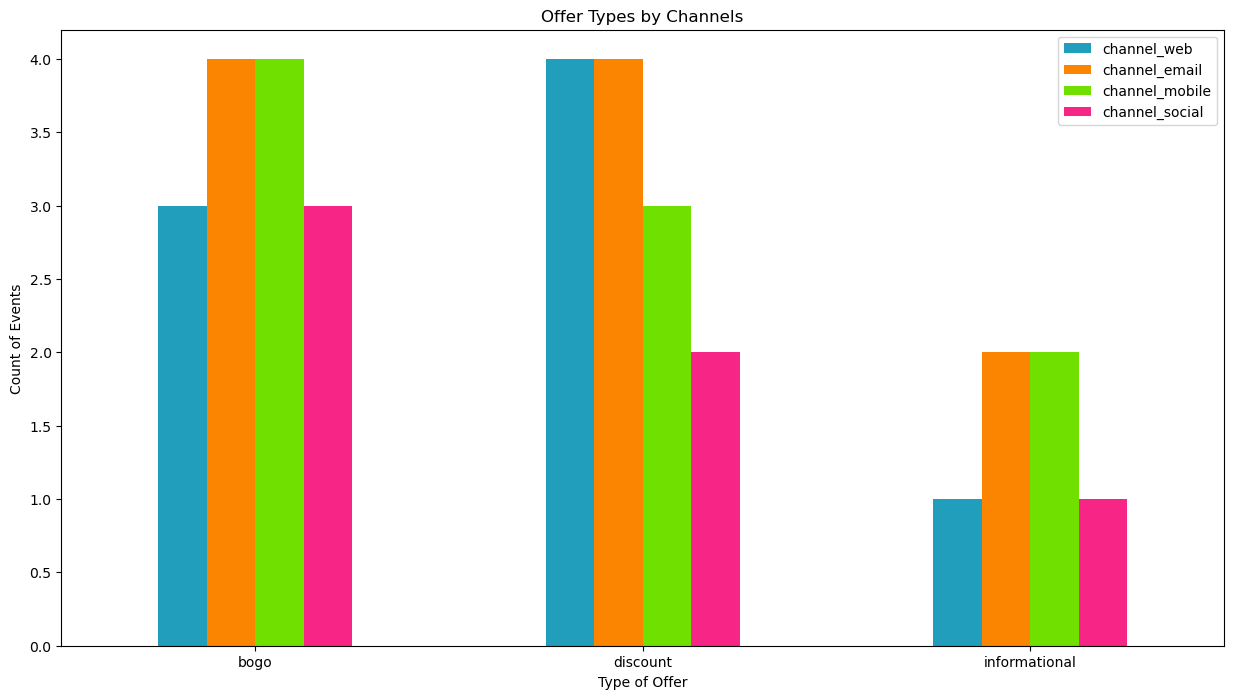

In [6]:
fig, ax = plt.subplots(figsize=(15,8))

portfolio.groupby('offer_type').sum()[['channel_web', 'channel_email', 'channel_mobile', 'channel_social']]\
.plot(kind='bar', ax=ax, color=["#219ebc","#fb8500","#70e000","#f72585"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_title('Offer Types by Channels')
ax.set_ylabel('Count of Events')
ax.set_xlabel('Type of Offer');

- The most popular channels for bogo offers were email and mobile.
- The most popular channels for discount offers were email and web.
- The most popular channels for informational offers were email and mobile.

### What is the best channel to send out promotions?

In [7]:
def clean_portfolio(portfolio):
    """
    Cleaning portfolio dataframe: one hot encoding of the channels and offer_type. 
    drop original channels columns. Keep original offer_type column
    
    Input: raw portfolio dataframe
    Output: cleaned portfolio dataframe
    """
    cleaned_data = portfolio.copy()

    # one hot encoding for channel column
    for channel in ['web', 'email', 'mobile', 'social']:
        cleaned_data[channel] = cleaned_data['channels'].apply(lambda x: 1 if channel in x else 0)

    # one hot encoding for offer_type column
    offer_type = pd.get_dummies(cleaned_data['offer_type'])
    cleaned_data = pd.concat([cleaned_data, offer_type], axis=1)
    # Keep original offer_type for exploratory analysis, only drop channels
    cleaned_data.drop(['channels'], axis=1, inplace=True)

    return cleaned_data

In [8]:
# Quickly examine the cleaned portfolio dataset
cleaned_portfolio = clean_portfolio(portfolio)
cleaned_portfolio

,reward,difficulty,duration,offer_type,id,offer_bogo,offer_discount,offer_informational,channel_email,channel_mobile,channel_social,channel_web,web,email,mobile,social,bogo,discount,informational
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0,1,1,1,0,0,1,1,1,1,0,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0,1,1,1,1,1,1,1,1,1,0,0
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,0,0,1,1,1,0,1,1,1,1,0,0,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,1,1,0,1,1,1,1,0,1,0,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,1,0,0,1,1,1,0,0,0,1,0
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,0,1,0,1,1,1,1,1,1,1,1,0,1,0
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,0,1,0,1,1,1,1,1,1,1,1,0,1,0
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,0,1,1,1,1,0,0,1,1,1,0,0,1
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0,1,1,1,1,1,1,1,1,1,0,0
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,0,1,0,1,1,0,1,1,1,1,0,0,1,0


In [9]:
def clean_transcript(transcript):
    """
    Clean transcript data: unpack value column, one hot encoding transaction event
    Input: raw transcript data
    Output: break values column to multiple columns, 
    """
    transcript_df = transcript.copy()
    
    # note: from_records need sequence index from 0
    transcript_df = transcript_df.join(pd.DataFrame.from_records(transcript_df.pop('value')))
    transcript_df.offer_id.update(transcript_df.pop('offer id')) # update non NaN values only
    
    # one hot encoding for event column
    event_df = pd.get_dummies(transcript_df['event'])
    transcript_df = pd.concat([transcript_df, event_df], axis=1)
   
    return transcript_df

In [10]:
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

cleaned_transcript = clean_transcript(transcript)
cleaned_transcript.head()

,person,event,time,amount,offer_id,reward,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,0,1,0,0


In [11]:
def clean_profile(profile):
    """
    Cleaning profile dataframe:
        remove customer who do not have gender or income data; one-hot encoding gender; feature engineering member date
    Input: profile dataframe to be cleaned
    Output: cleaned profile dataframe
    """
    cleaned_data = profile.copy()
    cleaned_data.loc[cleaned_data.age == 118, 'age'] = np.nan
    cleaned_data.dropna(inplace=True)
    cleaned_data['memberdays'] = datetime.datetime.today().date() - pd.to_datetime(cleaned_data['became_member_on'], 
                                                                              format='%Y%m%d').dt.date
    cleaned_data['memberdays'] = cleaned_data['memberdays'].dt.days
    cleaned_data['year_join'] = pd.to_datetime(cleaned_data['became_member_on'], format='%Y%m%d').dt.year
    # one hot encoding for event column
    gender_df = pd.get_dummies(cleaned_data['gender'])
    cleaned_data = pd.concat([cleaned_data, gender_df], axis=1)
    return cleaned_data

In [12]:
cleaned_profile = clean_profile(profile)
cleaned_profile.head()

,gender,age,id,became_member_on,income,memberdays,year_join,F,M,O
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,2083,2017,1,0,0
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,2150,2017,1,0,0
5,M,68.0,e2127556f4f64592b11af22de27a7932,20180426,70000.0,1798,2018,0,1,0
8,M,65.0,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,1874,2018,0,1,0
12,M,58.0,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,1964,2017,0,1,0


#### Aggregate Data set

In [13]:
all_data = cleaned_transcript.merge(cleaned_portfolio.rename(columns={"reward": "reward_p"}),
                                    left_on="offer_id", right_on="id")
all_data.drop(columns=['id'], inplace=True)
all_data.shape

(167581, 28)

In [14]:
def agg_event(df, col="offer_type", items=None):
    """
    aggregate offer completion rate
    df: whole or subset of the merged dataset
    col: column of interest
    items: selected items in the column
    """
    if not items:
        items = df[col].unique()
    item = items[0]
    event = pd.DataFrame(df[df[col] == item]['event'].value_counts())
    event.rename(columns={'event': item}, inplace=True)
    for item in items[1:]:
        event[item] = pd.DataFrame(df[df[col] == item]['event'].value_counts())
    event_T = event.T
    event_T['completed/received'] = event_T['offer completed'] / event_T['offer received']
    event_T['viewed/received'] = event_T['offer viewed'] / event_T['offer received']
    event_T['completed/viewed'] = event_T['offer completed'] / event_T['offer viewed']
    
    return event_T.sort_index()

,offer received,offer viewed,offer completed,completed/received,viewed/received,completed/viewed
bogo,22841.000000,18733.000000,11981.000000,0.524539,0.820148,0.639567
discount,30543.000000,21445.000000,17910.000000,0.586386,0.702125,0.835160
informational,7617.000000,4144.000000,nan,nan,0.544046,nan


,offer received,offer viewed,offer completed,completed/received,viewed/received,completed/viewed
bogo,30499.000000,25449.000000,15669.000000,0.513755,0.834421,0.615702
discount,30543.000000,21445.000000,17910.000000,0.586386,0.702125,0.835160
informational,15235.000000,10831.000000,nan,nan,0.710929,nan


,offer received,offer viewed,offer completed,completed/received,viewed/received,completed/viewed
bogo,30499.000000,25449.000000,15669.000000,0.513755,0.834421,0.615702
discount,22875.000000,18782.000000,14490.000000,0.633443,0.821071,0.771483
informational,15235.000000,10831.000000,nan,nan,0.710929,nan


,offer received,offer viewed,offer completed,completed/received,viewed/received,completed/viewed
bogo,22822.000000,21278.000000,11315.000000,0.495794,0.932346,0.531770
discount,15243.000000,14664.000000,10473.000000,0.687069,0.962015,0.714198
informational,7618.000000,6687.000000,nan,nan,0.877789,nan


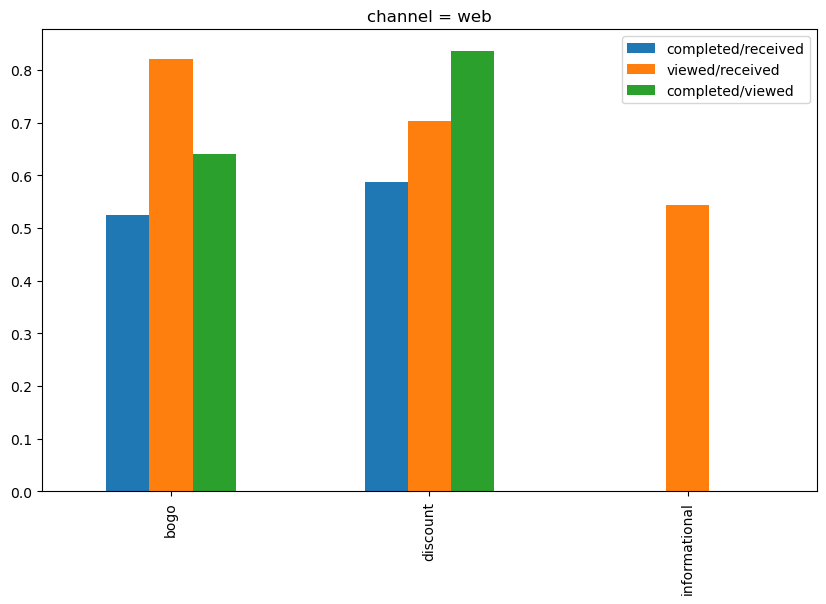

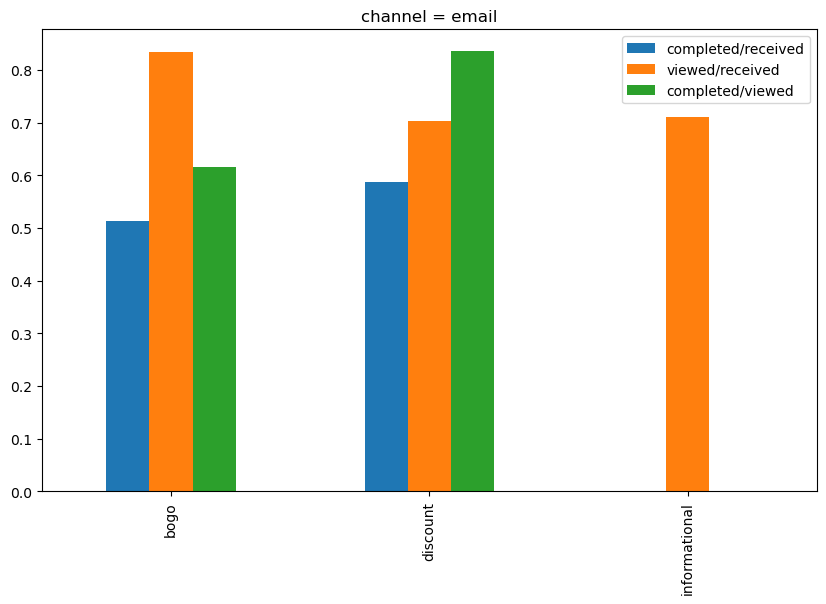

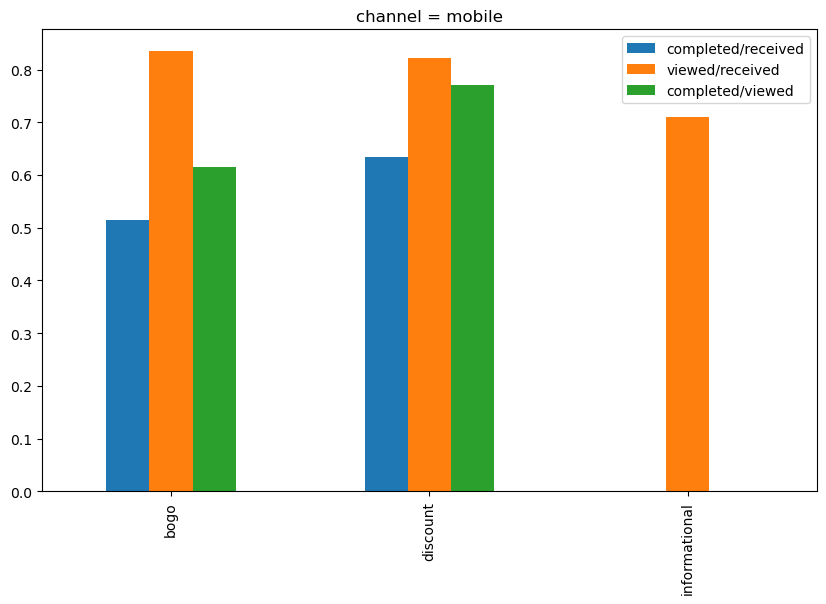

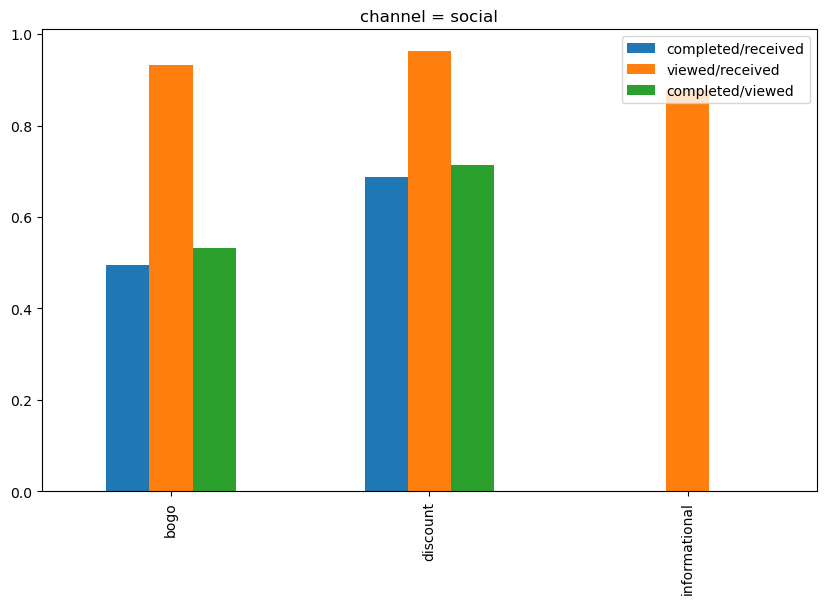

In [15]:
for channel in ['web', 'email', 'mobile', 'social']:
    agg = agg_event(all_data[(all_data[channel] == 1)], col='offer_type')
    title = "channel = {}".format(channel)
    display(agg.style.set_caption(title))
    agg[['completed/received', 'viewed/received', 'completed/viewed']].plot(kind="bar", figsize=(10, 6))
    plt.title(title)

Promotion through social media is more effective than other channels

***

### Can we build a model to predict the customers' behavior and send out customized promotional offers to individuals?

## Modeling and Evaluation

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn import model_selection

In [32]:
import warnings
warnings.filterwarnings('ignore') 

In [20]:
def evaluate_model_performance(model, X, y):
    """ Prints a model's accuracy and F1-score
    
    INPUT:
        model: Model object
        
        X: Training data matrix

        y: Expected model output vector
    
    OUTPUT:
        accuracy: Model accuracy
        
        f1_score: Model F1-score"""
    

    y_pred = model.predict(X)

    model_accuracy = accuracy_score(y, y_pred)
    model_f1_score = f1_score(y, y_pred)
    
    return model_accuracy, model_f1_score

In [21]:
# Generate dataset for model

offers = pd.DataFrame(all_data.groupby(['person', 'offer_id'])[['offer received', 'offer viewed', 'offer completed']].sum())
offers = offers.reset_index()
# Generate y label: either viewed=0 or completed=0 means not successful
offers['success'] = (offers['offer viewed'] * offers['offer completed']).astype(bool)

offers = offers.merge(cleaned_profile, left_on='person', right_on='id')
offers.drop(columns=['id'], inplace=True)
offers = offers.merge(cleaned_portfolio, left_on='offer_id', right_on='id')
offers.drop(columns=['id'], inplace=True)

print("Label success ratio = {}".format(offers.success.mean()))

Label success ratio = 0.42553692368983376


In [22]:
## select predictors
df_for_models = offers[['success', 'age', 'income', 'memberdays', 'F', 'M', 'O', 'reward', 'difficulty', 'duration',
                'web', 'mobile', 'social', 'bogo', 'discount', 'informational', 'year_join']]

print(df_for_models.mean())

y = df_for_models['success']
X = df_for_models.drop(['success'], axis=1)

# train test dataset split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

success              0.425537
age                 54.349969
income           65388.595125
memberdays        2228.272084
F                    0.413024
M                    0.573051
O                    0.013926
reward               4.204737
difficulty           7.718554
duration             6.508239
web                  0.799337
mobile               0.898808
social               0.599181
bogo                 0.399515
discount             0.400547
informational        0.199938
year_join         2016.624371
dtype: float64


In [23]:
df_for_models.head()

,success,age,income,memberdays,F,M,O,reward,difficulty,duration,web,mobile,social,bogo,discount,informational,year_join
0,False,33.0,72000.0,2168,0,1,0,2,10,7,1,1,0,0,1,0,2017
1,False,19.0,65000.0,2423,1,0,0,2,10,7,1,1,0,0,1,0,2016
2,False,56.0,47000.0,1936,0,1,0,2,10,7,1,1,0,0,1,0,2017
3,True,58.0,119000.0,1938,1,0,0,2,10,7,1,1,0,0,1,0,2017
4,True,26.0,61000.0,3020,0,1,0,2,10,7,1,1,0,0,1,0,2014


In [33]:
# Initial model implemenentation
models = [("LogisticRegression", LogisticRegression(solver='liblinear')),
          ("RandomForestClassifier", RandomForestClassifier()),
         ("GradientBoostingClassifier", GradientBoostingClassifier()),
         ("KNeighborsClassifier", KNeighborsClassifier())]

for model_pair in models:
    model_name = model_pair[0]
    model = model_pair[1]
    model.fit(X_train, y_train)
    training_accuracy, _ = evaluate_model_performance(model, X_train, y_train)
    testing_accuracy, _ = evaluate_model_performance(model, X_test, y_test)
    print(model_name)
    print("Traing accuracy: %.3f, testing accuracy: %.3f" % (training_accuracy, testing_accuracy))

LogisticRegression
Traing accuracy: 0.732, testing accuracy: 0.723
RandomForestClassifier
Traing accuracy: 1.000, testing accuracy: 0.744
GradientBoostingClassifier
Traing accuracy: 0.770, testing accuracy: 0.765
KNeighborsClassifier
Traing accuracy: 0.761, testing accuracy: 0.620


LogisticRegression: 0.709195 (0.021145)
RandomForestClassifier: 0.745027 (0.004131)
GradientBoostingClassifier: 0.766861 (0.004392)
KNeighborsClassifier: 0.619739 (0.009472)


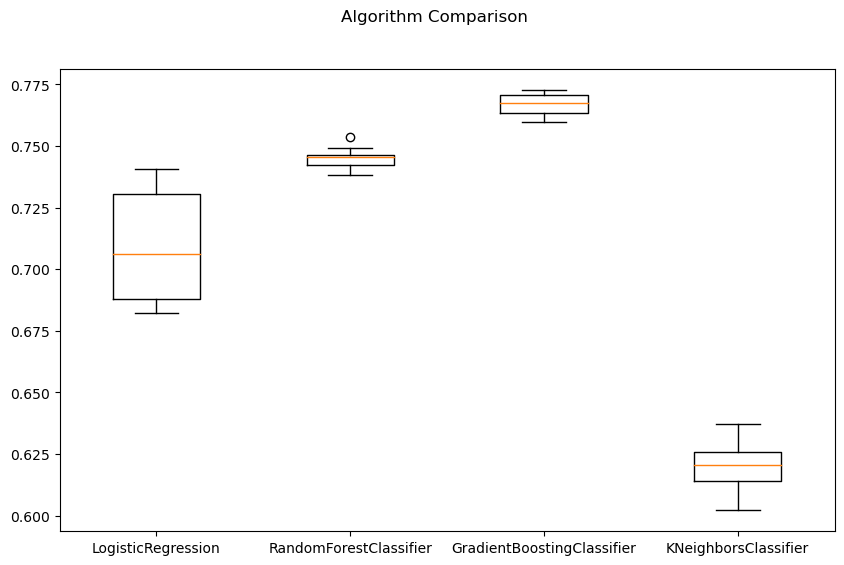

In [34]:
# evaluate each model in turn
seed = 7
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure(figsize=(10, 6))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

- The testing accuracy for Logistic regression and KNN classifier are low. 
- The Random forest classifier has overfitting issues.
- We will do refinement on Gradient boosting classifier.

#### Refinement
-  Add minmax scaler, use gradientboosting classifier

In [57]:
trans = MinMaxScaler()
model = GradientBoostingClassifier()
pipeline = Pipeline(steps=[('transformer', trans), ('model', model)])

# Fit model
pipeline.fit(X_train, y_train)

# Evaluation
training_accuracy, _ = evaluate_model_performance(pipeline, X_train, y_train)
testing_accuracy, _ = evaluate_model_performance(pipeline, X_test, y_test)
print("GradientBoostingClassifier Pipeline")
print("Traing accuracy: %.3f, testing accuracy: %.3f" % (training_accuracy, testing_accuracy))

GradientBoostingClassifier Pipeline
Traing accuracy: 0.770, testing accuracy: 0.765


In [58]:
# Check available parameters for further tuning
pipeline.get_params()

{'memory': None,
 'steps': [('transformer', MinMaxScaler()),
  ('model', GradientBoostingClassifier())],
 'verbose': False,
 'transformer': MinMaxScaler(),
 'model': GradientBoostingClassifier(),
 'transformer__copy': True,
 'transformer__feature_range': (0, 1),
 'model__ccp_alpha': 0.0,
 'model__criterion': 'friedman_mse',
 'model__init': None,
 'model__learning_rate': 0.1,
 'model__loss': 'deviance',
 'model__max_depth': 3,
 'model__max_features': None,
 'model__max_leaf_nodes': None,
 'model__min_impurity_decrease': 0.0,
 'model__min_impurity_split': None,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__min_weight_fraction_leaf': 0.0,
 'model__n_estimators': 100,
 'model__n_iter_no_change': None,
 'model__presort': 'deprecated',
 'model__random_state': None,
 'model__subsample': 1.0,
 'model__tol': 0.0001,
 'model__validation_fraction': 0.1,
 'model__verbose': 0,
 'model__warm_start': False}

In [59]:
parameters = {'model__n_estimators': [100, 120, 140],
              'model__min_samples_split': [2, 3]
              }
cv = GridSearchCV(pipeline, param_grid=parameters)
cv.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('transformer', MinMaxScaler()),
                                       ('model',
                                        GradientBoostingClassifier())]),
             param_grid={'model__min_samples_split': [2, 3],
                         'model__n_estimators': [100, 120, 140]})

In [60]:
cv.best_params_

{'model__min_samples_split': 2, 'model__n_estimators': 140}

In [61]:
cv.cv_results_

{'mean_fit_time': array([2.10689969, 2.51269994, 2.9359004 , 2.09190001, 2.48910017,
        2.9034996 ]),
 'std_fit_time': array([0.00653848, 0.02780282, 0.01774151, 0.02531996, 0.00786983,
        0.00551284]),
 'mean_score_time': array([0.01199913, 0.01349959, 0.01460018, 0.01200023, 0.0132997 ,
        0.01470094]),
 'std_score_time': array([1.06624030e-06, 1.16410786e-06, 4.91215867e-04, 3.16506985e-04,
        6.78205173e-04, 9.27685501e-04]),
 'param_model__min_samples_split': masked_array(data=[2, 2, 2, 3, 3, 3],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_model__n_estimators': masked_array(data=[100, 120, 140, 100, 120, 140],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'model__min_samples_split': 2, 'model__n_estimators': 100},
  {'model__min_samples_split': 2, 'model__n_estimators': 120},
  {'model__min_samples_spli

In [62]:
# The fine tuned model performs slightly better than original model
print("Fine tuned model")
training_accuracy, _ = evaluate_model_performance(cv, X_train, y_train)
testing_accuracy, _ = evaluate_model_performance(cv, X_test, y_test)
print("GradientBoostingClassifier Pipeline")
print("Traing accuracy: %.3f, testing accuracy: %.3f" % (training_accuracy, testing_accuracy))

Fine tuned model
GradientBoostingClassifier Pipeline
Traing accuracy: 0.773, testing accuracy: 0.767


In [93]:
y_pred = cv.predict(X_test)

In [94]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.80      0.80      0.80      9541
        True       0.73      0.73      0.73      7026

    accuracy                           0.77     16567
   macro avg       0.76      0.76      0.76     16567
weighted avg       0.77      0.77      0.77     16567



### Evaluating the result of the model
- Assuming we don't have a prediction model, and we ending up sending offers to everyone. 
- As a result, all the offers will be considered "success"


In [63]:
print("Accuracy score if we send offers to everyone %.3f" % accuracy_score(y, [True] * y.shape[0]))

Accuracy score if we send offers to everyone 0.426


In [64]:
print("Traing accuracy: %.3f, testing accuracy: %.3f" % (training_accuracy, testing_accuracy))

Traing accuracy: 0.773, testing accuracy: 0.767


### Conclusion

Assuming we don't have the predictive model, we'll send offers to all customers. Of all observations, 42.6% were labeled “True”. The accuracy score in this case will be 0.426. Our implemented model will increase the accuracy score from 0.426 to 0.767, which is an absolute improvement of 34.1%.

So we can conclude that our model had a good effectiveness and improvement in the results of promotions, with this model in production we can increase the company's profits by 34.1%.